In [1]:
import sys
import math
sys.path.insert(0,'../RandomGenerator/')
sys.path.insert(0,'../Cryptographie/RSA/')
from PrimeNumber import *
from RNG_UsualLaw_Continue import *
from scipy.stats import norm
from scipy.special import ndtri
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import time

Expectation : 1.0156989530825988
Variance : 12.050022301676695
Expectation : 0.2512024272174719
Variance : 0.06291179317333273
Expectation : 4.993054035159221
Variance : 10.033037297492777
[[ 1.         -0.55162059]
 [-0.55162059  1.        ]]
[0. 0.]
[-0.63884577  1.03232426]
Expectation : 13.306654276884533
Variance : 76.97856294123615
Expectation : 5.1037970080834585
Variance : 2286.7707145623403
Expectation : 5.9974714106678615
Variance : 11.868891581895644


Don't give importance to the computentional time because we mostly study convergence in this Jupyter Book

## Monte Carlo for Integral

Monte Carlo method to compute
$\begin{equation*}
\int_a^b f(x) dx
\end{equation*}$


Function to evaluate :

In [2]:
def f1(x):
    return(1/(1+x))

def f2(x):
    return(x*x + 2*x -3)

In [3]:
def MC(f,a,b,N=1000,alpha=0.05,conv=False):
    exact_result = integrate.quad(f,a,b)[0]
    res = []
    conv = []
    sample = Uniform_Continue(a,b,N)
    for i in range(N):
        res.append((b-a)*f(sample[i]))
        conv.append(abs(exact_result-np.mean(res)))
    sigma = np.std(res)
    sigma2 = np.var(res)
    quantil = ndtri(1-alpha/2)
    res = np.mean(res)
    print("Standard deviation :", sigma)
    print("Variance :",sigma2)
    print("Confidence interval of", 1-alpha,"% : [", res - quantil*sigma/math.sqrt(N), " : ",res + quantil*sigma/math.sqrt(N),"]")
    return res,conv

In [4]:
res,_ = MC(f1,0,1,N=3000)
print(res)
exact_result = integrate.quad(f1,0,1)
print("Exact result :",exact_result)

Standard deviation : 0.14427708492606311
Variance : 0.020815877234762425
Confidence interval of 0.95 % : [ 0.6969359872043954  :  0.7072615758212872 ]
0.7020987815128413
Exact result : (0.6931471805599454, 7.695479593116622e-15)


# Variance Reduction

### Antithetic variable

In [5]:
def MC_anthitetic(f,a,b,N=1000,alpha=0.05):
    exact_result = integrate.quad(f,a,b)[0]
    sample = Uniform_Continue(a,b,N)
    res = []
    conv = []
    for i in range(N):
        val = (b-a)* (f(sample[i]) + f(b-sample[i]+a))/2
        res.append(val)
        conv.append(abs(exact_result-np.mean(res)))
    sigma = np.std(res)
    sigma2 = np.var(res)
    res = np.mean(res)
    print("Standard deviation :", sigma)
    print("Variance :",sigma2)
    quantil = ndtri(1-alpha/2)
    print("Confidence interval of", 1-alpha,"% : [", res - quantil*sigma/math.sqrt(N), " : ",res + quantil*sigma/math.sqrt(N),"]")
    return res,conv

In [6]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f1,0,1,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res1),"\n \n")
print('\033[1m' + "Monte Carlo Antithetic Variates : " + '\033[0m')
start_time = time.time()
res2,_ = MC_anthitetic(f1,0,1,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 0.1397802863085356
Variance : 0.01953852844049618
Confidence interval of 0.95 % : [ 0.6884710675019866  :  0.6939503540402551 ]
Result : 0.6912107107711208 in 2.027021884918213 secondes
Error :  0.0019364697888245574 
 

Monte Carlo Antithetic Variates : 
Standard deviation : 0.02455937489469194
Variance : 0.0006031628952180247
Confidence interval of 0.95 % : [ 0.6929397260911856  :  0.6939024358967139 ]
Result : 0.6934210809939497 in 1.8830211162567139 secondes
Error :  0.00027390043400432607


In [7]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f2,3,5,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res1),"\n \n")
print('\033[1m' + "Monte Carlo Antithetic Variates : " + '\033[0m')
start_time = time.time()
res2,_ = MC_anthitetic(f2,3,5,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 11.598368842130432
Variance : 134.522159798102
Confidence interval of 0.95 % : [ 42.41561164818808  :  42.870259352387826 ]
Result : 42.642935500287955 in 1.954261064529419 secondes
Error :  0.023731166378709645 
 

Monte Carlo Antithetic Variates : 
Standard deviation : 0.5999281839605414
Variance : 0.35991382591019316
Confidence interval of 0.95 % : [ 42.66273179812061  :  42.68624855079808 ]
Result : 42.67449017445934 in 1.8712518215179443 secondes
Error :  0.007823507792679152


### Control Variate

In [8]:
def MC_control_variate(f,a,b,N=1000,alpha=0.05):
    exact_result = integrate.quad(f,a,b)[0]
    sample = Uniform_Continue(a,b,N)
    res = []
    conv = []
    m = []
    t = []
    for i in range(N):
        m.append(f(sample[i]))
        t.append(1+sample[i])
    c = - np.cov(m,t)[0,1]/np.var(t)
    m_star = []
    tau = (b+a+2)/2
    for i in range(N):
        m_star.append((b-a)* (m[i] + c*(t[i] - tau)))
        conv.append(abs(exact_result-np.mean(m_star)))
    print("mean t :",np.mean(t))
    sigma = np.std(m_star)
    sigma2 = np.var(m_star)
    res = np.mean(m_star)
    print("Standard deviation :", sigma)
    print("Variance :",sigma2)
    quantil = ndtri(1-alpha/2)
    print("Confidence interval of", 1-alpha,"% : [", res - quantil*sigma/math.sqrt(N), " : ",res + quantil*sigma/math.sqrt(N),"]")
    return res,conv

In [9]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f1,0,1,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res1),"\n \n")
print('\033[1m' + "Monte Carlo Antithetic Variates : " + '\033[0m')
start_time = time.time()
res2,_ = MC_control_variate(f1,0,1,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 0.13994660908884549
Variance : 0.019585053395466127
Confidence interval of 0.95 % : [ 0.6897327202620016  :  0.6952185265334545 ]
Result : 0.6924756233977281 in 1.8234550952911377 secondes
Error :  0.00067155716221734 
 

Monte Carlo Antithetic Variates : 
mean t : 1.5044776643153979
Standard deviation : 0.024854537714134435
Variance : 0.0006177480449833311
Confidence interval of 0.95 % : [ 0.6927644619334953  :  0.6937387419089373 ]
Result : 0.6932516019212163 in 3.6645920276641846 secondes
Error :  0.00010442136127086776


In [10]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f2,3,5,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res1),"\n \n")
print('\033[1m' + "Monte Carlo Antithetic Variates : " + '\033[0m')
start_time = time.time()
res2,_ = MC_control_variate(f2,3,5,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 11.559151895036683
Variance : 133.61399253253012
Confidence interval of 0.95 % : [ 42.58340652854543  :  43.036516956667434 ]
Result : 42.80996174260643 in 1.8418970108032227 secondes
Error :  0.14329507593976842 
 

Monte Carlo Antithetic Variates : 
mean t : 5.001300511548948
Standard deviation : 0.5930679086033985
Variance : 0.35172954421520913
Confidence interval of 0.95 % : [ 42.65222059030761  :  42.67546842513259 ]
Result : 42.6638445077201 in 3.850933074951172 secondes
Error :  0.002822158946564457


## Quasi Monte Carlo

### Naive method for generate low discrepency sequence on [0,1], $r_{i+1} \equiv (r_i + c )\mod 1$

The choice of constant $c$ is very important

In [11]:
def Naive_LD_sequence(n,dim,a=0,b=1):
    c = [np.sqrt(2)%1]
    len_c = 1
    number = 3
    while len_c < dim:
        if (is_prime_Miller(number,10)):
            c.append(np.sqrt(number)%1)
            len_c +=1 
        number +=1  
    c = [0.5545497,0.308517]
    s0 = 0.5
    sample = []
    for d in range(dim):
        s = [s0]
        for i in range(1,n):
            U = (s[i-1]+c[d])%1
            s.append(a+U*(b-a))
        sample.append(s)
    return sample

It works well on [0,1]

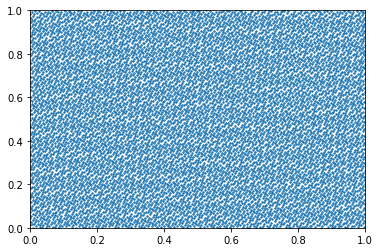

In [12]:
a,b = 0,1
n = 10000
sequence = Naive_LD_sequence(n,dim=2,a=a,b=b)
plt.scatter(sequence[0],sequence[1],s=2)
plt.axis([a,b,a,b])
plt.show()

But you can't transpose it on all interval $[a,b]$ such that $[3,5]$ for example

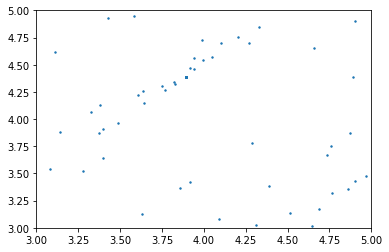

In [13]:
a,b = 3,5
n = 10000
sequence = Naive_LD_sequence(n,dim=2,a=a,b=b)
plt.scatter(sequence[0],sequence[1],s=2)
plt.axis([a,b,a,b])
plt.show()

(array([2.23762424e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.71287271e-04, 2.23762424e-03, 2.22979255e+00,
        2.01386181e-03, 2.68514908e-03]),
 array([0.5       , 0.94690256, 1.39380512, 1.84070768, 2.28761024,
        2.7345128 , 3.18141536, 3.62831792, 4.07522048, 4.52212304,
        4.9690256 ]),
 <a list of 10 Patch objects>)

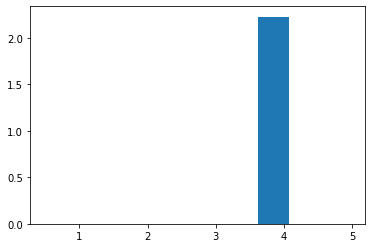

In [14]:
plt.hist(sequence[0],density=True)

Where a random sample on $[3,5]^2$ gives

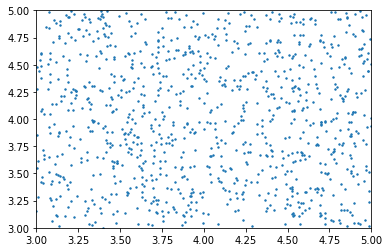

In [15]:
a,b = 3,5
n = 1000
sequence1 = Uniform_Continue(a,b,n)
sequence2 = Uniform_Continue(a,b,n)
plt.scatter(sequence1,sequence2,s=2)
plt.axis([a,b,a,b])
plt.show()

In [16]:
def QMC_naive(f,a,b,N=1000,alpha=0.05):
    exact_result = integrate.quad(f,a,b)[0]
    res = []
    conv = []
    sample = Naive_LD_sequence(N,1,a,b)[0]
    for i in range(N):
        res.append((b-a)*f(sample[i]))
        conv.append(abs(exact_result-np.mean(res)))
    sigma = np.std(res)
    sigma2 = np.var(res)
    quantil = ndtri(1-alpha/2)
    res = np.mean(res)
    print("Standard deviation :", sigma)
    print("Variance :",sigma2)
    print("Confidence interval of", 1-alpha,"% : [", res - quantil*sigma/math.sqrt(N), " : ",res + quantil*sigma/math.sqrt(N),"]")
    return res,conv

This QMC works on only on $[0,1]$

In [17]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f1,0,1,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res1),"\n \n")
print('\033[1m' + "Quasi Monte Carlo naive sequence : " + '\033[0m')
start_time = time.time()
res2,_ = QMC_naive(f1,0,1,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 0.1394718561914463
Variance : 0.01945239866948748
Confidence interval of 0.95 % : [ 0.6890179973458528  :  0.6944851936456964 ]
Result : 0.6917515954957746 in 2.197996139526367 secondes
Error :  0.0013955850641708123 
 

Quasi Monte Carlo naive sequence : 
Standard deviation : 0.1398735037151551
Variance : 0.01956459704155351
Confidence interval of 0.95 % : [ 0.6905887584893242  :  0.6960716990827869 ]
Result : 0.6933302287860555 in 2.1242728233337402 secondes
Error :  0.0001830482261101496


Quasi Monte Carlo with this sequence do not work very well for compute integral not in $[0,1]$

In [18]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f2,3,5,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res1),"\n \n")
print('\033[1m' + "Quasi Monte Carlo naive sequence : " + '\033[0m')
start_time = time.time()
res2,_ = QMC_naive(f2,3,5,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 11.521757432637626
Variance : 132.7508943365404
Confidence interval of 0.95 % : [ 42.36638915923834  :  42.81803375136987 ]
Result : 42.5922114553041 in 2.0829241275787354 secondes
Error :  0.07445521136256161 
 

Quasi Monte Carlo naive sequence : 
Standard deviation : 0.929955477293994
Variance : 0.8648171897491
Confidence interval of 0.95 % : [ 39.83572906202258  :  39.87218264687702 ]
Result : 39.8539558544498 in 2.0751020908355713 secondes
Error :  2.8127108122168636


### Van Der Corput

Van Der Corput sequence works better on all interval $[a,b]$ and even on multi dimensional space wheareas the base choice if prime for each direction

In [19]:
def VanDerCoput_sequence(n,base=2,a=0,b=1):
    sample =[a]
    for i in range(1,n):
        phi = 0.0
        number = str(np.base_repr(i,base=base))
        j = -len(number)
        for c in number:
            phi+= int(c,base)*pow(base,j)
            j = j+1
        sample.append(a + phi*(b-a))
    return sample

(array([1.0214011 , 1.00137363, 1.00137363, 0.99135989, 1.00137363,
        1.00137363, 0.99135989, 1.01138736, 1.00137363, 0.99135989]),
 array([4.        , 4.09986283, 4.19972565, 4.29958848, 4.3994513 ,
        4.49931413, 4.59917695, 4.69903978, 4.79890261, 4.89876543,
        4.99862826]),
 <a list of 10 Patch objects>)

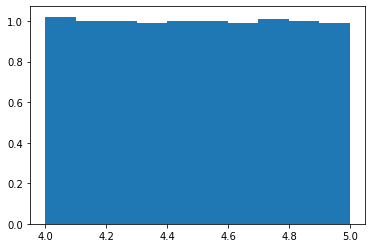

In [20]:
seq = VanDerCoput_sequence(1000,3,4,5)
plt.hist(seq,density=True)

In [21]:
def VanDerCoput_multidim_sequence(n,dim,a=0,b=1):
    base_array = [2]
    len_base = 1
    number = 3
    while len_base < dim:
        if (is_prime_Miller(number,10)):
            base_array.append(number)
            len_base +=1 
        number +=1  
    sample = []
    for d in range(dim):
        print("base :",base_array[d])
        sample.append(VanDerCoput_sequence(n,base_array[d],a,b))
    return sample

Van Der Corput Sequence in dimension $4$ on $a=3$ and $b=5$

base : 2
base : 3
base : 5
base : 7
base : 11
base : 13
base : 17
base : 19
base : 23
base : 29
base : 31


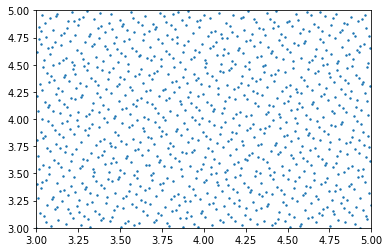

In [22]:
a,b = 3,5
n = 1000
sequence = VanDerCoput_multidim_sequence(n,11,a,b)
plt.scatter(sequence[1],sequence[0],s=2)
plt.axis([a,b,a,b])
plt.show()

Max dimension is 11 because of $\textit{np.base_repr()}$ allowed only to base 36.

Allowing greater base there is no limitation on the dimension.

Remarks : above 30 dimensions there is some limitations of the Van Der Corput sequence (called Halton sequence when it's in multidimensional)

(array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]),
 array([4.        , 4.09090909, 4.18181818, 4.27272727, 4.36363636,
        4.45454545, 4.54545455, 4.63636364, 4.72727273, 4.81818182,
        4.90909091]),
 <a list of 10 Patch objects>)

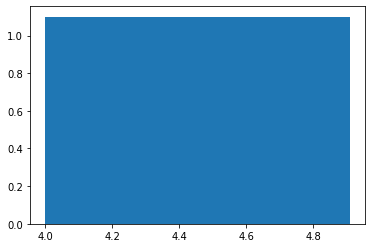

In [23]:
seq = VanDerCoput_sequence(20,11,4,5)
plt.hist(seq,density=True)

In [24]:
def QMC_VanDerCorput(f,a,b,N=1000,alpha=0.05):
    exact_result = integrate.quad(f,a,b)[0]
    res = []
    conv = []
    sample = VanDerCoput_sequence(N,2,a,b)
    for i in range(N):
        res.append((b-a)*f(sample[i]))
        conv.append(abs(exact_result-np.mean(res)))
    sigma = np.std(res)
    sigma2 = np.var(res)
    quantil = ndtri(1-alpha/2)
    res = np.mean(res)
    print("Standard deviation :", sigma)
    print("Variance :",sigma2)
    print("Confidence interval of", 1-alpha,"% : [", res - quantil*sigma/math.sqrt(N), " : ",res + quantil*sigma/math.sqrt(N),"]")
    return res,conv

In [25]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f1,0,1,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res1),"\n \n")
print('\033[1m' + "Quasi Monte Carlo Van Der Corput sequence : " + '\033[0m')
start_time = time.time()
res2,_ = QMC_VanDerCorput(f1,0,1,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f1,0,1)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 0.14142293638465486
Variance : 0.020000446935658132
Confidence interval of 0.95 % : [ 0.6906484900067201  :  0.6961921672447565 ]
Result : 0.6934203286257383 in 1.8095848560333252 secondes
Error :  0.0002731480657929275 
 

Quasi Monte Carlo Van Der Corput sequence : 
Standard deviation : 0.1398461309548536
Variance : 0.019556940343042062
Confidence interval of 0.95 % : [ 0.6904920010478401  :  0.6959738686488159 ]
Result : 0.693232934848328 in 1.8358290195465088 secondes
Error :  8.575428838264454e-05


In [26]:
N=10000
print('\033[1m' + "Monte Carlo Standard : " + '\033[0m')
start_time = time.time()
res1,_ = MC(f2,3,5,N)
print("Result :",res1,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res1),"\n \n")
print('\033[1m' + "Quasi Monte Carlo Van Der Corput sequence : " + '\033[0m')
start_time = time.time()
res2,_ = QMC_VanDerCorput(f2,3,5,N)
print("Result :",res2,"in",time.time() - start_time,"secondes")
print("Error : ",abs(integrate.quad(f2,3,5)[0]-res2))

Monte Carlo Standard : 
Standard deviation : 11.548983729799053
Variance : 133.37902519116327
Confidence interval of 0.95 % : [ 42.682562022348314  :  43.13527386571722 ]
Result : 42.908917944032765 in 1.811213731765747 secondes
Error :  0.2422512773661012 
 

Quasi Monte Carlo Van Der Corput sequence : 
Standard deviation : 11.561649044330883
Variance : 133.67172862427722
Confidence interval of 0.95 % : [ 42.43322819291857  :  42.886436507494174 ]
Result : 42.65983235020637 in 2.70579195022583 secondes
Error :  0.0068343164602922


# Study of the convergence

First we study on $[3,5]$ for a smooth funnction $f(x) = \frac{1}{1+x}$

In [27]:
a ,b = 3,5
N = pow(10,5)
print("MC standard...")
_,conv_mc_standard = MC(f2,a,b,N)
print("MC anthitetic variable...")
_,conv_mc_anthitetic_variable = MC_anthitetic(f2,a,b,N)
print("MC control variate...")
_,conv_mc_control_variate =MC_control_variate(f2,a,b,N)
print("QMC...")
_,conv_qmc = QMC_VanDerCorput(f2,a,b,N)

MC standard...
Standard deviation : 11.577448279048228
Variance : 134.0373086540368
Confidence interval of 0.95 % : [ 42.60771811386174  :  42.75123101246408 ]
MC anthitetic variable...


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,8))
x = np.linspace(0,N,50)
plt.plot(range(N)[0::int(N/10)],conv_mc_standard[0::int(N/10)],color="b")
plt.plot(range(N)[0::int(N/10)],conv_mc_anthitetic_variable[0::int(N/10)],color="r")
plt.plot(range(N)[0::int(N/10)],conv_mc_control_variate[0::int(N/10)],color="g")
plt.plot(range(N)[0::int(N/10)],conv_qmc[0::int(N/10)],color="black")
plt.legend(['MC standard','MC Anthitetic variable','MC control variate','QMC'])
plt.yscale('log')
plt.title('Convergence')
plt.xlabel("Number of simulations")
plt.ylabel("Error")
#plt.xscale('log')